In [1]:
!nvidia-smi

Fri Nov  3 07:22:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:06:00.0 Off |                    0 |
| N/A   34C    P0              41W / 300W |      0MiB / 16384MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import cv2 as cv2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import itertools
import equinox
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from csaps import csaps


import torch
from scipy.stats import norm, binom_test
import numpy as np
from math import ceil, sqrt
from statsmodels.stats.proportion import proportion_confint
from scipy import stats

import kornia

from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import StepLR
import time

from tqdm.auto import tqdm
import math

In [1]:
import imgaug

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
!nvidia-smi

Fri May 12 19:13:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   51C    P0   164W / 300W |  10263MiB / 16160MiB |     47%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [6]:
device= torch.device('cuda:4')

In [2]:
import os
import sys
sys.path.append('./..')
from tqdm import tqdm
import argparse
import torch
import torchvision
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


import datetime
# from tensorboardX import SummaryWriter
import wandb


from train_utils import AverageMeter, accuracy, init_logfile, log
from datasets0 import get_dataset, DATASETS, get_normalize_layer
from architectures import ARCHITECTURES, get_architecture

ModuleNotFoundError: No module named 'datasets0'

In [ ]:
wandb.init(project="general_lipschitz", name = "test_run", tags = ["ResNet50", "BT"])

**Many modules and functions might be now imported from `src`, no need to put them into the notebook, e.g. `imshow`, attacks and augmentations (`_phi`) transforms**

In [26]:
def imshow(img):
    img = img # / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
from typing import *
def get_normalize_layer(dataset: str) -> torch.nn.Module:
    """Return the dataset's normalization layer"""
    if dataset == "imagenet":
        return NormalizeLayer(_IMAGENET_MEAN, _IMAGENET_STDDEV)
    elif dataset == "cifar10":
        return NormalizeLayer(_CIFAR10_MEAN, _CIFAR10_STDDEV)
    elif dataset == "mnist":
        return NormalizeLayer(_MNIST_MEAN, _MNIST_STDDEV)
    else:
        raise Exception("Unknown dataset")
        
_IMAGENET_MEAN = [0.485, 0.456, 0.406]
_IMAGENET_STDDEV = [0.229, 0.224, 0.225]


def _imagenet(split: str) -> Dataset:
    if not IMAGENET_LOC_ENV in os.environ:
        raise RuntimeError("environment variable for ImageNet directory not set")

    dir = os.environ[IMAGENET_LOC_ENV]
    if split == "train":
        subdir = os.path.join(dir, "train")
        transform = transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
    elif split == "test":
        subdir = os.path.join(dir, "val")
        transform = transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
    return datasets.ImageFolder(subdir, transform)



class NormalizeLayer(torch.nn.Module):
    """Standardize the channels of a batch of images by subtracting the dataset mean
      and dividing by the dataset standard deviation.

      In order to certify radii in original coordinates rather than standardized coordinates, we
      add the Gaussian noise _before_ standardizing, which is why we have standardization be the first
      layer of the classifier rather than as a part of preprocessing as is typical.
      """

    def __init__(self, means: List[float], sds: List[float]):
        """
        :param means: the channel means
        :param sds: the channel standard deviations
        """
        super(NormalizeLayer, self).__init__()
        self.means = torch.tensor(means).to(device)
        self.sds = torch.tensor(sds).to(device)
        self.means = torch.tensor(means).to(device)
        self.sds = torch.tensor(sds).to(device)
    def forward(self, input: torch.tensor):
        (batch_size, num_channels, height, width) = input.shape
        means = self.means.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2).contiguous()
        sds = self.sds.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2).contiguous()
        return (input - means) / sds

In [10]:
q ={'dataset':"imagenet"}


In [11]:
!ls /workspace/raid/data/ReportResults

BrightTrans_08_408_2023_checkpoint.pth.tar
TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar
events.out.tfevents.1683886282.948b4f83b7e7
events.out.tfevents.1683886876.948b4f83b7e7
events.out.tfevents.1683886943.948b4f83b7e7
events.out.tfevents.1683888259.948b4f83b7e7
gcBrightTrans_08_408_2023_checkpoint.pth.tar
gcTransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar
log.txt


In [12]:
outdir = "/workspace/raid/data/ReportResults"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [13]:
# from semantic.transformers import gen_transformer, AbstractTransformer
def kl_div(input, targets, reduction='batchmean'):    return F.kl_div(F.log_softmax(input, dim=1), targets,
                    reduction=reduction)


def _cross_entropy(input, targets, reduction='mean'):
    targets_prob = F.softmax(targets, dim=1)
    xent = (-targets_prob * F.log_softmax(input, dim=1)).sum(1)
    if reduction == 'sum':
        return xent.sum()
    elif reduction == 'mean':
        return xent.mean()
    elif reduction == 'none':
        return xent
    else:
        raise NotImplementedError()


def _entropy(input, reduction='mean'):
    return _cross_entropy(input, input, reduction)




def _chunk_minibatch(batch, num_batches):
    X, y = batch
    batch_size = len(X) // num_batches
    for i in range(num_batches):
        yield X[i*batch_size : (i+1)*batch_size], y[i*batch_size : (i+1)*batch_size]



def train(loader: DataLoader, model: torch.nn.Module, criterion, optimizer, epoch: int,
          transformer, args, writer=None, name=None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_reg = AverageMeter()
    confidence = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    # switch to train mode
    model.train()

    for i, batch in enumerate(tqdm(loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        mini_batches = _chunk_minibatch(batch, args['num_noise_vec'])
        for inputs, targets in mini_batches:
            targets = targets.to(device)
            batch_size = inputs.size(0)

            noised_inputs = [transformer(inputs.to(device)) for _ in range(args['num_noise_vec'])]

            # augment inputs with noise
            inputs_c = torch.cat(noised_inputs, dim=0)
            targets_c = targets.repeat(args['num_noise_vec'])

            logits = model(inputs_c)

            loss_xent = criterion(logits, targets_c)

            logits_chunk = torch.chunk(logits, args['num_noise_vec'], dim=0)
            softmax = [F.softmax(logit, dim=1) for logit in logits_chunk]
            avg_softmax = sum(softmax) /args['num_noise_vec']

            consistency = [kl_div(logit, avg_softmax, reduction='none').sum(1)
                           + _entropy(avg_softmax, reduction='none')
                           for logit in logits_chunk]
            consistency = sum(consistency) / args['num_noise_vec']
            consistency = consistency.mean()

            loss = loss_xent + args['lbd'] * consistency

            avg_confidence = -F.nll_loss(avg_softmax, targets)

            acc1, acc5 = accuracy(logits, targets_c, topk=(1, 5))
            losses.update(loss_xent.item(), batch_size)
            losses_reg.update(consistency.item(), batch_size)
            confidence.update(avg_confidence.item(), batch_size)
            top1.update(acc1.item(), batch_size)
            top5.update(acc5.item(), batch_size)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args['print_freq'] == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.avg:.3f}\t'
                  'Data {data_time.avg:.3f}\t'
                  'Loss {loss.avg:.4f}\t'
                  'Acc@1 {top1.avg:.3f}\t'
                  'Acc@5 {top5.avg:.3f}'.format(
                epoch, i, len(loader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))
            
            torch.save({
            'epoch': epoch + 1,
            'arch': args['arch'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, os.path.join(outdir, args['transtype']+name+'_checkpoint.pth.tar'))
            wandb.log({
                f'epoch/{epoch}/loss/train': losses.avg,
                f'epoch/{epoch}/loss/consistency': losses_reg.avg,
                f'epoch/{epoch}/loss/avg_confidence': confidence.avg,
                f'epoch/{epoch}/batch_time': batch_time.avg,
                f'epoch/{epoch}/accuracy/train@1': top1.avg,
                f'epoch/{epoch}/accuracy/train@5': top5.avg
                
            })

    
    wandb.log({
        "epoch": epoch,
        'loss/train': losses.avg,
        'loss/consistency': losses_reg.avg,
        'loss/avg_confidence': confidence.avg,
        'batch_time': batch_time.avg,
        'accuracy/train@1': top1.avg,
        'accuracy/train@5': top5.avg
        
    })

    return (losses.avg, top1.avg)


def test(loader, model, criterion, epoch, transformer, writer=None, print_freq=10):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    # switch to eval mode
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(loader)):
            # measure data loading time
            data_time.update(time.time() - end)

            inputs = inputs
            targets = targets.to(device)

            # augment inputs with noise
            inputs = transformer(inputs.to(device))

            # compute output
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(acc1.item(), inputs.size(0))
            top5.update(acc5.item(), inputs.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.avg:.3f}\t'
                      'Data {data_time.avg:.3f}\t'
                      'Loss {loss.avg:.4f}\t'
                      'Acc@1 {top1.avg:.3f}\t'
                      'Acc@5 {top5.avg:.3f}'.format(
                    i, len(loader), batch_time=batch_time, data_time=data_time,
                    loss=losses, top1=top1, top5=top5))

        wandb.log({
            'loss/test': losses.avg,
            'accuracy/test@1': top1.avg,
            'accuracy/test@5': top5.avg
        
        })


        return (losses.avg, top1.avg)



In [14]:
# import torchvision.transforms.functional as F_t
# def norm_to_exp_torch(a):
#     return torch.log(2/torch.erfc(a/torch.sqrt(torch.tensor(2))))

# def Blur(tensor, kernel_size):
# #     kernel_size=
#     return F_t.gaussian_blur(tensor, kernel_size, sigma=None)


# def attack_tbbc_torch(x, b): #trans bright blur contrast

#     x = x.to(device)
#     translation = torch.tensor([[b[0].item(), b[1].item()]]).to(torch.float).to(device) #torch.tensor()
#     out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    
    
#     b2 = torch.tensor(b[2])
#     b2 = (2 * torch.floor(b2/2) + 1).int().item()
#     out = Blur(out, b2) 

#     out = out + b[3]

#     out = torch.tensor(b[4].item())* out
#     return out

# def phi_tbbc_torch_batch_and_noise(x, sigma_tr =40, sigma_b = 0.8, sigma_bl = torch.sqrt(torch.tensor(30)), sigma_c=0.8): #trans bright blur contrast
#     x = x.to(device)
#     c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
#     c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
#     t = torch.tensor([1,0])
#     T = t.expand(len(x), *t.shape).clone()
#     T[:, 0] = c1.squeeze().clone()
#     T[:, 1] = c2.squeeze().clone()
    
#     out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    

    
#     bl = sigma_bl * norm_to_exp_torch(torch.randn(len(x)))
#     bl = (2 * torch.floor (bl/2) + 1).to(torch.int)
    
#     blur_radii = [r.cpu().item() for r in bl]
#     for i in range(len(out)):
#         out[i] = Blur(out[i], blur_radii[i])

#     b = torch.randn(len(x)) * sigma_b
    
#     b = b[:,None,None,None].to(device)
#     out = out + b
    
    

#     c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None]
#     out = c.to(device)*out

#     return out


In [15]:
def phi_bt_torch_batch_and_noise(x, sigma=0.8, tau=50):
#     x = x.expand(nsamples, *x.shape)
    x = x.to(device)
    
    q = torch.randn(len(x)) * sigma
    q = q[:,None,None,None]
    x = x + q.to(device)
    
    c1 = (torch.randn(len(x)) * tau).long()*1.0
    c2 = (torch.randn(len(x)) * tau).long()*1.0
    
    c1 = c1[:, None, None, None]
    c2 = c2[:, None, None, None]
    
#     nx, ny = c1, c2
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    out = kornia.geometry.transform.translate(x, T.float().to(device), padding_mode='reflection')
    return out


# def phi_bt_torch_batch(x, c):
# #     x = x.expand(nsamples, *x.shape)
#     x = x.to(device)
#     q = c[0][:,None,None,None]
#     x = x + q.to(device)
#     c1 = c[1][:, None, None, None]
#     c2 = c[2][:, None, None, None]
# #     nx, ny = c1  * np.sqrt(30.), c2  * np.sqrt(30.)
#     t = torch.tensor([1,0])
#     T = t.expand(nsamples, *t.shape).clone()
#     T[:, 0] = c1.squeeze().clone()
#     T[:, 1] = c2.squeeze().clone()
#     out = kornia.geometry.transform.translate(x, T.float().to(device), padding_mode='reflection')
#     return out
    

# def phi_bt_torch(x, c):
#     x = x + torch.tensor(c[0].item())
#     nx, ny = c[1]  * 30, c[2]*30
#     translation = torch.tensor([[nx.item(), ny.item()]])
#     out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    
#     return out

def attack_bt_torch(x, b):
    x = x.to(device) + torch.tensor(b[0].item())
    
    translation = torch.tensor([[b[1].item(), b[2].item()]]).to(device) #torch.tensor()

    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
#     print('Shape after attack', out.shape)
    return out

In [24]:
epochs = 2
lr=1e-3
momentum=0.95
weight_decay=1e-4
lr_step_size =1
gamma=0.1
dataset='imagenet'
batch = 128
workers = 8

print_freq=2
arch='resnet50'
pin_memory = False
logfilename = os.path.join(outdir, 'log.txt')

In [16]:
train_dataset = get_dataset(dataset, 'train')
test_dataset = get_dataset(dataset, 'test')
pin_memory = False#(args.dataset == "imagenet")
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch,
                          num_workers = workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch,
                         num_workers = workers, pin_memory=pin_memory)




logfilename = os.path.join(outdir, 'log.txt')
init_logfile(logfilename, "epoch\ttime\tlr\ttrain loss\ttrain acc\ttestloss\ttest acc")
# writer = SummaryWriter(outdir)

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:919: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:312: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


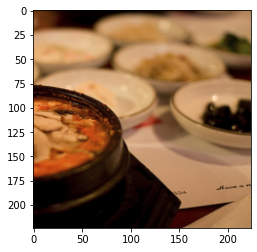

In [96]:
imshow(batch[0])

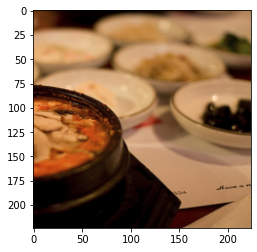

In [97]:
imshow(batch[1])

In [98]:
transformed_batch = phi_bt_torch_batch_and_noise(batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


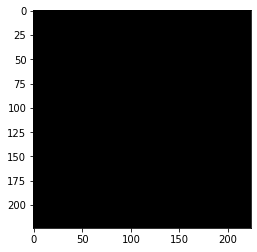

In [100]:
imshow(transformed_batch[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


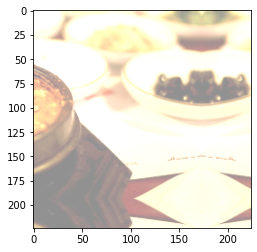

In [101]:
imshow(transformed_batch[1].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


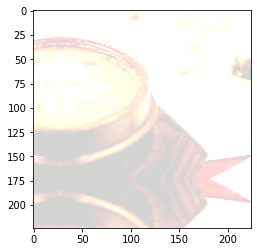

In [102]:
imshow(transformed_batch[2].cpu())

In [217]:
!ls /workspace/raid/data/ReportResults

BrightTrans_08_408_2023_checkpoint.pth.tar
TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar
events.out.tfevents.1683886282.948b4f83b7e7
events.out.tfevents.1683886876.948b4f83b7e7
events.out.tfevents.1683886943.948b4f83b7e7
events.out.tfevents.1683888259.948b4f83b7e7
gcBrightTrans_08_408_2023_checkpoint.pth.tar
gcTransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar
log.txt


In [54]:
checkpoint = torch.load("/workspace/raid/data/ReportResults/gcTransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar")
model = torchvision.models.resnet50(pretrained=False)
normalize_layer = get_normalize_layer('imagenet')
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [64]:
model = torchvision.models.resnet50(pretrained=True, progress=True)
normalize_layer = get_normalize_layer('imagenet')
model = torch.nn.Sequential(normalize_layer, model)

# model.eval()
model = model.to(device)

In [65]:
criterion = CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

In [66]:
transformer = phi_bt_torch_batch_and_noise
epoch=0

In [67]:
# test(test_loader, model, criterion, epoch, transformer, writer=None, print_freq=10)

In [68]:
args = {'lr':lr, 'num_noise_vec':1, 'lbd':20, 'print_freq':10, 'arch':'resnet50', 'transtype':'gc', 'print_step':10 }

In [69]:
name = 'BrightTrans_08_408_2023'

In [76]:
for epoch in range(epochs):
    before = time.time()
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, transformer, args, writer, name=name)
    test_loss, test_acc = test(test_loader, model, criterion, epoch, transformer, writer, print_freq)
    after = time.time()

    scheduler.step(epoch)

    log(logfilename, "{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))
    
    print("{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))

    torch.save({
        'epoch': epoch + 1,
        'arch': arch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(outdir, name+'_checkpoint.pth.tar'))

  0%|                                                 | 0/10010 [00:00<?, ?it/s]

Epoch: [0][0/10010]	Time 3.513	Data 3.270	Loss 1.7517	Acc@1 57.031	Acc@5 79.688


  1%|▏                                          | 2/391 [00:02<07:55,  1.22s/it]

Test: [0/391]	Time 2.741	Data 2.598	Loss 2.1337	Acc@1 67.188	Acc@5 76.562


  1%|▍                                          | 4/391 [00:03<03:17,  1.95it/s]

Test: [2/391]	Time 1.023	Data 0.886	Loss 2.0955	Acc@1 60.417	Acc@5 78.125
Test: [4/391]	Time 0.675	Data 0.539	Loss 1.8706	Acc@1 65.156	Acc@5 81.406


  1%|▍                                          | 4/391 [00:04<07:01,  1.09s/it]
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0	0:0	0.001	1.91	58.8	1.87	65.2


  0%|                                                 | 0/10010 [00:00<?, ?it/s]

Epoch: [1][0/10010]	Time 3.205	Data 2.985	Loss 1.6576	Acc@1 65.625	Acc@5 78.906


  0%|                                           | 1/391 [00:02<16:35,  2.55s/it]

Test: [0/391]	Time 2.552	Data 2.399	Loss 1.1638	Acc@1 75.000	Acc@5 89.062


  1%|▍                                          | 4/391 [00:03<03:21,  1.92it/s]

Test: [2/391]	Time 1.018	Data 0.871	Loss 1.5409	Acc@1 65.625	Acc@5 86.458
Test: [4/391]	Time 0.678	Data 0.536	Loss 1.2433	Acc@1 71.719	Acc@5 89.219


  1%|▍                                          | 4/391 [00:04<06:54,  1.07s/it]


1	0:0	1e-05	1.9	59.5	1.24	71.7


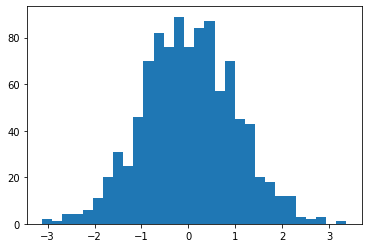

In [44]:
def norm_to_exp_torch(a):
    return torch.log(2/torch.erfc(a/torch.sqrt(torch.tensor(2))))
sig = 30
a = torch.randn(1000)#*sig

plt.hist(a.numpy(), bins=30)
plt.show()

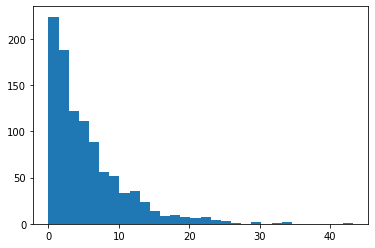

In [45]:
b = np.sqrt(sig)*norm_to_exp_torch(a).numpy()
plt.hist(b, bins=30)
plt.show()

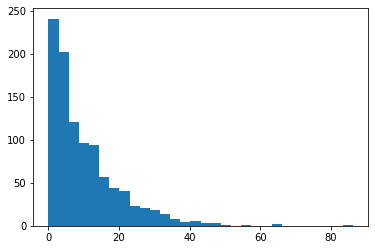

In [46]:
plt.hist(np.random.exponential(10, size=1000), bins=30)
plt.show()

In [16]:
import torchvision.transforms.functional as F_t

# Translation-Brightness-Blur-Contrast 

In [223]:
# import torchvision.transforms.functional as F_t
# def Blur(tensor, kernel_sizes):
#     kernel_sizes = list(kernel_sizes.numpy())
# #     kernel_size = int(kernel_size)
    
# #     if kernel_size%2==0:
# #         kernel_size +=1
#     return F_t.gaussian_blur(tensor, kernel_sizes, sigma=None)

In [224]:
# gauss = kornia.filters.GaussianBlur2d((11, 11), (10.5, 10.5))

# # blur the image
# x_blur: torch.tensor = gauss(batch.float())


In [27]:
import cv2 

class Gaussian:
    # it adopts uniform distribution
    def __init__(self, sigma):
        self.sigma = sigma
        self.sigma2 = sigma ** 2.0

    def gen_param(self):
        r = random.uniform(0.0, self.sigma2)
        return r

    def proc(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
        input = input.cpu().numpy()
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        return out #.cuda()
    
    def proc_new(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
#         print(input.shape)
        input = input.cpu().numpy()
#         print(input.shape)
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        
        return out #.cuda()

    def batch_proc(self, inputs):
        outs = torch.zeros_like(inputs)
        for i in range(len(inputs)):
            outs[i] = self.proc(inputs[i], self.gen_param())
        return outs
    
class ExpGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(ExpGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.exponential(scale=self.sigma)
        r = r#.to(device)
        return r
    
class RayGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(RayGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.rayleigh(scale=self.sigma)
        return r

In [28]:
# kernel_size = tuple(map(int, np.ceil(3*np.array(s)) // 2 * 2 + 1))

In [29]:
Xs, ys = next(iter(train_loader))
batch = Xs[0].repeat(16, 1, 1, 1)

In [30]:
blurer = imgaug.augmenters.blur.GaussianBlur(sigma = [0, 3])
out = blurer.augment(images=batch.cpu().numpy().transpose(0,2,3,1))
out = torch.from_numpy(out.transpose(0,3,1,2)) #.to(device)

/tmp/ipykernel_33282/1996323277.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imshow(torch.tensor(out[0]))


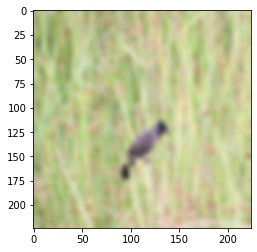

In [31]:
imshow(torch.tensor(out[0]))

/tmp/ipykernel_33282/648823952.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imshow(torch.tensor(out[2]))


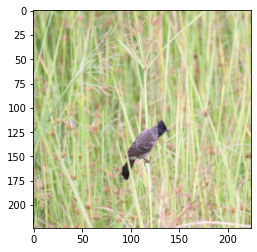

In [32]:
imshow(torch.tensor(out[2]))

In [33]:
s = [0, 3]

In [34]:
kernel_size = tuple(map(int, np.ceil(3*np.array(s)) // 2 * 2 + 1))
kernel_size

(1, 9)

In [35]:
blur = ExpGaussian(10)
out = blur.batch_proc(out)

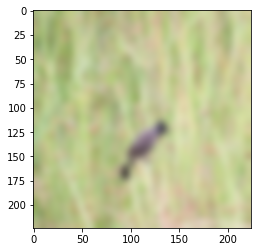

In [36]:
imshow(out[1])

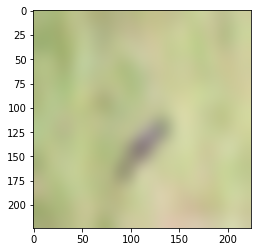

In [37]:
blurer = imgaug.augmenters.blur.GaussianBlur(sigma = [0, 10])
out = blurer.augment(images=out.cpu().numpy().transpose(0,2,3,1))
out = torch.from_numpy(out.transpose(0,3,1,2)).to(device)
imshow(out[1].cpu())

In [38]:
def phi_tbbc_torch_batch_and_noise(x, sigma_tr=40, sigma_b = 0.4, sigma_bl=10, sigma_c=0.4): #trans bright blur contrast, but it was supossed to be translation-BLUR-BRIGHT-contrast
    x = x.to(device)
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    
    b = torch.randn(len(x)) * sigma_b
    b = b[:, None, None, None].to(device)
    out = out + b
    
    ###### v1
    blur = ExpGaussian(sigma_bl)
    out = blur.batch_proc(out)
    ##### v2 
#     blurer = imgaug.augmenters.blur.GaussianBlur(sigma = [0, sigma_bl])
#     out = blurer.augment(images=out.cpu().numpy().transpose(0,2,3,1))
#     out = torch.from_numpy(out.transpose(0,3,1,2)).to(device)

    c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    out = c * out

    return out



In [39]:
batch = Xs[0].repeat(16, 1, 1, 1)
transformed_batch = phi_tbbc_torch_batch_and_noise(batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


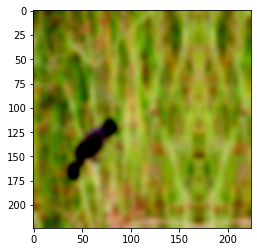

In [40]:
imshow(transformed_batch[6].cpu())

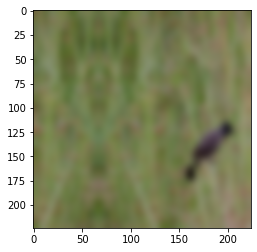

In [41]:
imshow(transformed_batch[2].cpu())

In [42]:
outdir

'/workspace/raid/data/ReportResults'

In [43]:
epochs = 2
lr=1e-3
momentum=0.95
weight_decay=1e-4
lr_step_size =1
gamma=0.1
dataset='imagenet'
batch = 128
workers = 8

print_freq=2
arch='resnet50'
pin_memory = False
logfilename = os.path.join(outdir, 'log_TBBC.txt')

In [44]:
train_dataset = get_dataset(dataset, 'train')
test_dataset = get_dataset(dataset, 'test')
pin_memory = False
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch,
                          num_workers = workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch,
                         num_workers = workers, pin_memory=pin_memory)




logfilename = os.path.join(outdir, 'log_TBBC.txt')
init_logfile(logfilename, "epoch\ttime\tlr\ttrain loss\ttrain acc\ttestloss\ttest acc")

In [45]:
model = torchvision.models.resnet50(pretrained=True, progress=True)
normalize_layer = get_normalize_layer('imagenet')
model = torch.nn.Sequential(normalize_layer, model)
model = model.to(device)

In [46]:
criterion = CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

In [47]:
transformer = phi_tbbc_torch_batch_and_noise

In [48]:
args = {'lr':lr, 'num_noise_vec':1, 'lbd':20, 'print_freq':10, 'arch':'resnet50', 'transtype':'tbbc', 'print_step':10 }

In [49]:
name = 'TransBrightBlurContrast_40_04_10_04'

In [ ]:
wandb.init(project="general_lipschitz", name="TBBC_hope", tags = ["ResNet50", "TBBC"])

In [ ]:
for epoch in range(epochs):
    before = time.time()
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, transformer, args, writer=None, name=name)
    test_loss, test_acc = test(test_loader, model, criterion, epoch, transformer, writer=None, print_freq=print_freq)
    after = time.time()

    scheduler.step(epoch)

    log(logfilename, "{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))
    
    print("{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))

    torch.save({
        'epoch': epoch + 1,
        'arch': arch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(outdir, name+'_checkpoint.pth.tar'))

  0%|                                                 | 0/10010 [00:00<?, ?it/s]

Epoch: [0][0/10010]	Time 9.516	Data 2.541	Loss 4.4421	Acc@1 19.531	Acc@5 44.531


  0%|                                      | 10/10010 [00:37<9:18:22,  3.35s/it]

Epoch: [0][10/10010]	Time 3.736	Data 0.288	Loss 4.1422	Acc@1 25.142	Acc@5 46.165


  0%|                                      | 20/10010 [01:12<9:45:30,  3.52s/it]

Epoch: [0][20/10010]	Time 3.630	Data 0.186	Loss 3.8788	Acc@1 28.088	Acc@5 49.219


  0%|                                      | 30/10010 [01:44<8:48:07,  3.18s/it]

Epoch: [0][30/10010]	Time 3.474	Data 0.149	Loss 3.7511	Acc@1 29.511	Acc@5 51.109


  0%|▏                                     | 40/10010 [02:17<9:13:05,  3.33s/it]

Epoch: [0][40/10010]	Time 3.443	Data 0.130	Loss 3.6180	Acc@1 31.193	Acc@5 53.258


  0%|▏                                     | 50/10010 [02:54<9:57:20,  3.60s/it]

Epoch: [0][50/10010]	Time 3.481	Data 0.119	Loss 3.5326	Acc@1 32.338	Acc@5 54.289


  1%|▏                                     | 60/10010 [03:29<9:30:09,  3.44s/it]

Epoch: [0][60/10010]	Time 3.488	Data 0.111	Loss 3.4785	Acc@1 33.069	Acc@5 54.803


  1%|▎                                     | 70/10010 [04:04<9:16:06,  3.36s/it]

Epoch: [0][70/10010]	Time 3.493	Data 0.106	Loss 3.4224	Acc@1 33.924	Acc@5 55.414


  1%|▎                                    | 80/10010 [04:42<10:15:20,  3.72s/it]

Epoch: [0][80/10010]	Time 3.528	Data 0.102	Loss 3.3881	Acc@1 34.307	Acc@5 55.951


  1%|▎                                     | 90/10010 [05:15<8:53:01,  3.22s/it]

Epoch: [0][90/10010]	Time 3.503	Data 0.098	Loss 3.3434	Acc@1 34.942	Acc@5 56.550


  1%|▎                                    | 100/10010 [05:48<8:57:23,  3.25s/it]

Epoch: [0][100/10010]	Time 3.485	Data 0.095	Loss 3.3032	Acc@1 35.512	Acc@5 57.116


  1%|▍                                    | 110/10010 [06:24<9:53:11,  3.60s/it]

Epoch: [0][110/10010]	Time 3.500	Data 0.093	Loss 3.2716	Acc@1 35.923	Acc@5 57.531


  1%|▍                                    | 120/10010 [07:00<9:23:36,  3.42s/it]

Epoch: [0][120/10010]	Time 3.500	Data 0.091	Loss 3.2455	Acc@1 36.189	Acc@5 58.058


  1%|▍                                    | 130/10010 [07:33<9:07:58,  3.33s/it]

Epoch: [0][130/10010]	Time 3.494	Data 0.090	Loss 3.2268	Acc@1 36.343	Acc@5 58.421


  1%|▌                                    | 140/10010 [08:09<9:08:45,  3.34s/it]

Epoch: [0][140/10010]	Time 3.492	Data 0.089	Loss 3.2055	Acc@1 36.475	Acc@5 58.766


  1%|▌                                    | 150/10010 [08:42<9:07:57,  3.33s/it]

Epoch: [0][150/10010]	Time 3.488	Data 0.088	Loss 3.1847	Acc@1 36.802	Acc@5 59.101


  2%|▌                                    | 160/10010 [09:18<9:44:09,  3.56s/it]

Epoch: [0][160/10010]	Time 3.490	Data 0.087	Loss 3.1665	Acc@1 37.088	Acc@5 59.317


  2%|▋                                    | 170/10010 [09:53<9:52:25,  3.61s/it]

Epoch: [0][170/10010]	Time 3.490	Data 0.086	Loss 3.1535	Acc@1 37.144	Acc@5 59.530


  2%|▋                                    | 180/10010 [10:29<9:59:33,  3.66s/it]

Epoch: [0][180/10010]	Time 3.498	Data 0.085	Loss 3.1389	Acc@1 37.345	Acc@5 59.807


  2%|▋                                    | 190/10010 [11:05<9:36:40,  3.52s/it]

Epoch: [0][190/10010]	Time 3.502	Data 0.084	Loss 3.1220	Acc@1 37.504	Acc@5 60.111


  2%|▋                                    | 200/10010 [11:40<9:39:07,  3.54s/it]

Epoch: [0][200/10010]	Time 3.498	Data 0.083	Loss 3.1008	Acc@1 37.819	Acc@5 60.409


  2%|▊                                    | 210/10010 [12:14<9:12:53,  3.39s/it]

Epoch: [0][210/10010]	Time 3.497	Data 0.083	Loss 3.0831	Acc@1 38.044	Acc@5 60.689


  2%|▊                                    | 220/10010 [12:50<9:31:11,  3.50s/it]

Epoch: [0][220/10010]	Time 3.506	Data 0.082	Loss 3.0658	Acc@1 38.267	Acc@5 60.966


  2%|▊                                    | 230/10010 [13:24<8:30:56,  3.13s/it]

Epoch: [0][230/10010]	Time 3.499	Data 0.082	Loss 3.0539	Acc@1 38.491	Acc@5 61.134


  2%|▉                                    | 240/10010 [13:59<8:53:19,  3.28s/it]

Epoch: [0][240/10010]	Time 3.494	Data 0.082	Loss 3.0389	Acc@1 38.699	Acc@5 61.414


  2%|▉                                    | 250/10010 [14:34<9:32:56,  3.52s/it]

Epoch: [0][250/10010]	Time 3.497	Data 0.081	Loss 3.0257	Acc@1 38.885	Acc@5 61.669


  3%|▉                                    | 260/10010 [15:09<9:10:10,  3.39s/it]

Epoch: [0][260/10010]	Time 3.498	Data 0.081	Loss 3.0155	Acc@1 39.042	Acc@5 61.841


  3%|▉                                    | 270/10010 [15:46<9:47:26,  3.62s/it]

Epoch: [0][270/10010]	Time 3.505	Data 0.080	Loss 3.0023	Acc@1 39.218	Acc@5 62.045


  3%|█                                    | 280/10010 [16:22<9:38:01,  3.56s/it]

Epoch: [0][280/10010]	Time 3.508	Data 0.080	Loss 2.9883	Acc@1 39.407	Acc@5 62.283


  3%|█                                    | 290/10010 [16:56<9:06:24,  3.37s/it]

Epoch: [0][290/10010]	Time 3.501	Data 0.080	Loss 2.9776	Acc@1 39.543	Acc@5 62.479


  3%|█                                    | 300/10010 [17:29<9:29:17,  3.52s/it]

Epoch: [0][300/10010]	Time 3.497	Data 0.079	Loss 2.9676	Acc@1 39.717	Acc@5 62.565


  3%|█▏                                   | 310/10010 [18:04<9:23:40,  3.49s/it]

Epoch: [0][310/10010]	Time 3.501	Data 0.079	Loss 2.9596	Acc@1 39.819	Acc@5 62.681


  3%|█▏                                   | 320/10010 [18:39<8:54:09,  3.31s/it]

Epoch: [0][320/10010]	Time 3.498	Data 0.079	Loss 2.9484	Acc@1 40.012	Acc@5 62.802


  3%|█▏                                   | 330/10010 [19:15<9:48:16,  3.65s/it]

Epoch: [0][330/10010]	Time 3.502	Data 0.079	Loss 2.9376	Acc@1 40.129	Acc@5 62.963


  3%|█▎                                   | 340/10010 [19:50<9:06:58,  3.39s/it]

Epoch: [0][340/10010]	Time 3.500	Data 0.079	Loss 2.9339	Acc@1 40.169	Acc@5 63.038


  3%|█▎                                   | 350/10010 [20:24<8:58:03,  3.34s/it]

Epoch: [0][350/10010]	Time 3.497	Data 0.078	Loss 2.9271	Acc@1 40.264	Acc@5 63.137


  4%|█▎                                   | 360/10010 [20:57<9:06:11,  3.40s/it]

Epoch: [0][360/10010]	Time 3.493	Data 0.078	Loss 2.9176	Acc@1 40.426	Acc@5 63.309


  4%|█▎                                   | 370/10010 [21:33<9:18:18,  3.47s/it]

Epoch: [0][370/10010]	Time 3.495	Data 0.078	Loss 2.9108	Acc@1 40.522	Acc@5 63.416


  4%|█▍                                   | 380/10010 [22:06<8:31:23,  3.19s/it]

Epoch: [0][380/10010]	Time 3.490	Data 0.078	Loss 2.9041	Acc@1 40.617	Acc@5 63.523


  4%|█▍                                   | 390/10010 [22:39<8:45:26,  3.28s/it]

Epoch: [0][390/10010]	Time 3.485	Data 0.078	Loss 2.8984	Acc@1 40.701	Acc@5 63.595


  4%|█▍                                   | 400/10010 [23:12<8:44:59,  3.28s/it]

Epoch: [0][400/10010]	Time 3.483	Data 0.078	Loss 2.8933	Acc@1 40.783	Acc@5 63.671


  4%|█▌                                   | 410/10010 [23:46<8:43:24,  3.27s/it]

Epoch: [0][410/10010]	Time 3.479	Data 0.078	Loss 2.8844	Acc@1 40.933	Acc@5 63.800


  4%|█▌                                   | 420/10010 [24:19<8:52:12,  3.33s/it]

Epoch: [0][420/10010]	Time 3.476	Data 0.078	Loss 2.8753	Acc@1 41.069	Acc@5 63.925


  4%|█▌                                   | 430/10010 [24:57<9:56:09,  3.73s/it]

Epoch: [0][430/10010]	Time 3.483	Data 0.077	Loss 2.8691	Acc@1 41.145	Acc@5 64.019


  4%|█▋                                   | 440/10010 [25:31<9:09:05,  3.44s/it]

Epoch: [0][440/10010]	Time 3.481	Data 0.077	Loss 2.8622	Acc@1 41.220	Acc@5 64.130


  4%|█▋                                   | 450/10010 [26:09<9:29:24,  3.57s/it]

Epoch: [0][450/10010]	Time 3.487	Data 0.077	Loss 2.8565	Acc@1 41.332	Acc@5 64.199


  5%|█▋                                   | 460/10010 [26:43<9:07:25,  3.44s/it]

Epoch: [0][460/10010]	Time 3.486	Data 0.077	Loss 2.8500	Acc@1 41.388	Acc@5 64.285


  5%|█▋                                   | 470/10010 [27:17<8:51:37,  3.34s/it]

Epoch: [0][470/10010]	Time 3.483	Data 0.077	Loss 2.8453	Acc@1 41.434	Acc@5 64.344


  5%|█▊                                   | 480/10010 [27:50<9:06:16,  3.44s/it]

Epoch: [0][480/10010]	Time 3.482	Data 0.077	Loss 2.8429	Acc@1 41.440	Acc@5 64.387


  5%|█▊                                   | 490/10010 [28:25<9:00:16,  3.41s/it]

Epoch: [0][490/10010]	Time 3.480	Data 0.077	Loss 2.8383	Acc@1 41.508	Acc@5 64.484


  5%|█▊                                   | 500/10010 [28:59<8:38:36,  3.27s/it]

Epoch: [0][500/10010]	Time 3.478	Data 0.076	Loss 2.8343	Acc@1 41.525	Acc@5 64.532


  5%|█▉                                   | 510/10010 [29:32<8:37:47,  3.27s/it]

Epoch: [0][510/10010]	Time 3.474	Data 0.076	Loss 2.8297	Acc@1 41.593	Acc@5 64.596


  5%|█▉                                   | 520/10010 [30:07<9:25:18,  3.57s/it]

Epoch: [0][520/10010]	Time 3.476	Data 0.076	Loss 2.8299	Acc@1 41.582	Acc@5 64.619


  5%|█▉                                   | 530/10010 [30:41<8:43:35,  3.31s/it]

Epoch: [0][530/10010]	Time 3.474	Data 0.076	Loss 2.8231	Acc@1 41.683	Acc@5 64.733


  5%|█▉                                   | 540/10010 [31:16<9:30:32,  3.61s/it]

Epoch: [0][540/10010]	Time 3.476	Data 0.076	Loss 2.8171	Acc@1 41.754	Acc@5 64.809


  5%|██                                   | 550/10010 [31:51<8:58:35,  3.42s/it]

Epoch: [0][550/10010]	Time 3.476	Data 0.076	Loss 2.8132	Acc@1 41.796	Acc@5 64.855


  6%|██                                   | 560/10010 [32:25<8:11:13,  3.12s/it]

Epoch: [0][560/10010]	Time 3.474	Data 0.076	Loss 2.8095	Acc@1 41.837	Acc@5 64.919


  6%|██                                   | 570/10010 [33:01<9:50:46,  3.75s/it]

Epoch: [0][570/10010]	Time 3.477	Data 0.076	Loss 2.8067	Acc@1 41.888	Acc@5 64.968


  6%|██▏                                  | 580/10010 [33:35<7:50:44,  3.00s/it]

Epoch: [0][580/10010]	Time 3.474	Data 0.076	Loss 2.8013	Acc@1 41.952	Acc@5 65.054


  6%|██▏                                  | 590/10010 [34:10<9:27:50,  3.62s/it]

Epoch: [0][590/10010]	Time 3.475	Data 0.076	Loss 2.7953	Acc@1 42.039	Acc@5 65.150


  6%|██▏                                  | 600/10010 [34:43<8:20:04,  3.19s/it]

Epoch: [0][600/10010]	Time 3.472	Data 0.076	Loss 2.7909	Acc@1 42.090	Acc@5 65.196


  6%|██▎                                  | 610/10010 [35:18<9:02:53,  3.47s/it]

Epoch: [0][610/10010]	Time 3.472	Data 0.075	Loss 2.7871	Acc@1 42.163	Acc@5 65.249


  6%|██▎                                  | 620/10010 [35:53<8:52:59,  3.41s/it]

Epoch: [0][620/10010]	Time 3.474	Data 0.075	Loss 2.7829	Acc@1 42.235	Acc@5 65.309


  6%|██▎                                  | 630/10010 [36:28<8:33:16,  3.28s/it]

Epoch: [0][630/10010]	Time 3.474	Data 0.075	Loss 2.7785	Acc@1 42.310	Acc@5 65.367


  6%|██▎                                  | 640/10010 [37:03<9:04:35,  3.49s/it]

Epoch: [0][640/10010]	Time 3.474	Data 0.075	Loss 2.7741	Acc@1 42.391	Acc@5 65.448


  6%|██▎                                  | 641/10010 [37:07<9:33:12,  3.67s/it]

In [52]:
2+2

4

In [86]:
# def attack_tbbc_torch(x, b): #trans bright blur contrast

#     x = x.to(device)
#     translation = torch.tensor([[b[0].item(), b[1].item()]]).to(device) #torch.tensor()
#     out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
#     out = out + b[2]

#     out = Blur(out, torch.tensor(b[3]).to(torch.int)) 
#     out = torch.tensor(b[4].item())* out
#     return out

In [212]:
!ls /workspace/raid/data/datasets/imagenet/

ILSVRC2012_img_val.tar	train  two  val


In [214]:
!du -sh /workspace/raid/data/datasets/imagenet/train

140G	/workspace/raid/data/datasets/imagenet/train


In [ ]:
https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_train.tar

In [53]:
name

'TransBrightBlurContrast_40_04_10_04'